## Load data

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# Load Dataset
import glob
import numpy as np
from pprint import pprint


folder_path = '/media/dataset2/jiwon/noise2noise/latent_mlp/sample/unet_upscaling_reg_full/model_195epoch/'
# folder_path = '/media/dataset1/project/jiwon/noise2noise/latent_mlp/sample/unet_dm/'


# 0_initial_latent.pt
initial_latents = sorted(glob.glob(folder_path + '*_noise.npy'), key=lambda x: int(x.split('/')[-1].split('_')[0]))
# 0_latent.pt
inversion_latents = sorted(glob.glob(folder_path + '*_pred.npy'), key=lambda x: int(x.split('/')[-1].split('_')[0]))
# 0_recon.png
initial_latents_loaded = []
inversion_latents_loaded = []

for i in range(len(initial_latents)):
    initial_latents_loaded.append(np.load(initial_latents[i]))
    inversion_latents_loaded.append(np.load(inversion_latents[i]))

print('initial_latents:', len(initial_latents))
print('inversion_latents:', len(inversion_latents))


initial_latents: 30
inversion_latents: 30


mean : 256.01275634765625, std : 0.8815457820892334
min: -4.811313629150391 max: 4.938827037811279


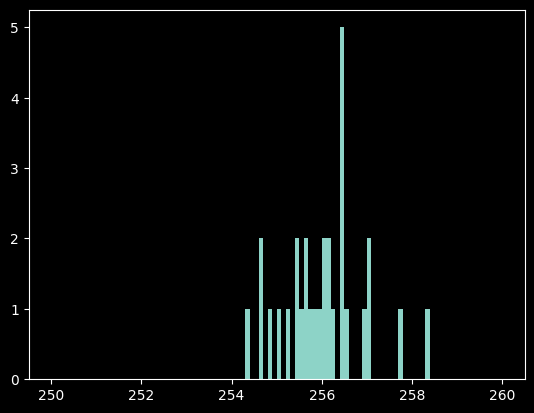

In [2]:
initial_latents = np.concatenate(initial_latents_loaded, axis=0)
norms = np.linalg.norm(initial_latents.reshape(initial_latents.shape[0], -1), axis=1)
import matplotlib.pyplot as plt
plt.hist(norms, bins=100, range=(250,260))
print(f"mean : {np.mean(norms)}, std : {np.std(norms)}")
print(f"min: {np.min(initial_latents)} max: {np.max(initial_latents)}")


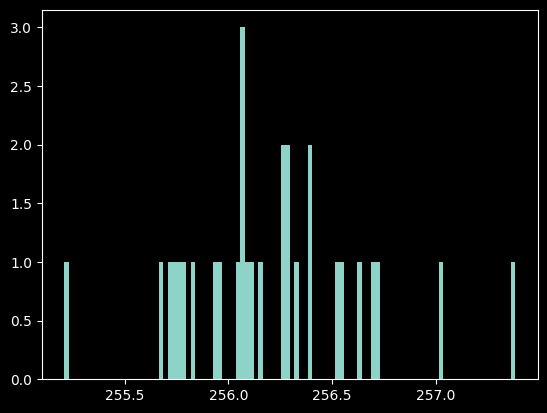

mean : 256.1982116699219, std : 0.4296555817127228
min: -4.191577434539795 max: 4.678506374359131
(65536,)


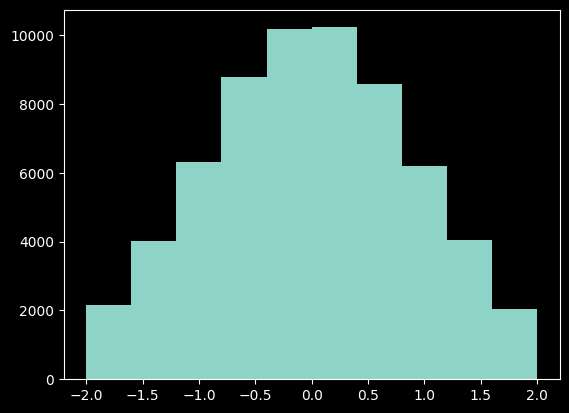

In [3]:
inversion_latents = np.concatenate(inversion_latents_loaded, axis=0)
norms = np.linalg.norm(inversion_latents.reshape(inversion_latents.shape[0], -1), axis=1)
import matplotlib.pyplot as plt
plt.hist(norms, bins=100)
plt.show()

print(f"mean : {np.mean(norms)}, std : {np.std(norms)}")
print(f"min: {np.min(inversion_latents[0])} max: {np.max(inversion_latents[0])}")
plt.hist(inversion_latents[0].reshape(-1), range=(-2,2))
print(inversion_latents[0].reshape(-1).shape)
plt.show()

# SDXL

In [4]:
from diffusers import AutoPipelineForText2Image
from diffusers.schedulers import DDIMScheduler
import torch
import PIL

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16")
# pipe.to("cuda")


/home/cvlab02/anaconda3/envs/noise2noise/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s]


In [5]:
from tqdm import tqdm
prompt = "A corgi riding a skateboard"
# prompt = "A man driving a car on the road"

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 50
# high_noise_frac = 0.8

for num_img in tqdm(range(len(initial_latents))):
    # run both experts
    image = pipe(
        prompt=prompt,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        latents = torch.Tensor(initial_latents_loaded[num_img]).to(torch.float16),
    )[0]
    image2 = pipe(
        prompt=prompt,
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        latents = torch.Tensor(inversion_latents_loaded[num_img]).to(torch.float16),
    )[0]
    image_cfg = pipe(
        prompt=prompt,
        num_inference_steps=n_steps,
        guidance_scale=7.5,
        latents = torch.Tensor(initial_latents_loaded[num_img]).to(torch.float16),
    )[0]
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))  # Increase figure size for higher resolution
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(image[0])
    plt.title('Original Noise Sample')
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(image2[0])
    plt.title('Predicted Noise Sample ')
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(image_cfg[0])
    plt.title('Original Noise Sample CFG 7.5')
    plt.savefig(folder_path +str(num_img) + '_comparison.png', bbox_inches='tight')

  0%|          | 0/30 [00:00<?, ?it/s]

device: cpu


  0%|          | 0/30 [02:30<?, ?it/s]


KeyboardInterrupt: 

# Kolors

In [ ]:
import torch

from diffusers import DPMSolverMultistepScheduler, KolorsPipeline

pipe = KolorsPipeline.from_pretrained("Kwai-Kolors/Kolors-diffusers", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True)

from tqdm import tqdm
prompt = "A corgi riding a skateboard"

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 50
# high_noise_frac = 0.8

for num_img in tqdm(range(len(initial_latents))):
    # run both experts
    image = pipe(
        prompt=prompt,
        negative_prompt="",
        guidance_scale=0.0,
        num_inference_steps=25,
        latents = torch.Tensor(initial_latents_loaded[num_img]).to(torch.float16),
    ).images[0]
    image2 = pipe(
        prompt=prompt,
        negative_prompt="",
        guidance_scale=0.0,
        num_inference_steps=25,
        latents = torch.Tensor(inversion_latents_loaded[num_img]).to(torch.float16),
    ).images[0]

    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.savefig(folder_path + str(num_img) + '_comparison_kolors.png')


# SD3
- Latent Dim이 16x128x128인 관계로, 기존의 4x128x128 호환 불가능

In [ ]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

In [ ]:
from tqdm import tqdm
prompt = "A corgi riding a skateboard"

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 50
# high_noise_frac = 0.8

for num_img in tqdm(range(len(initial_latents))):
    # run both experts
    image = pipe(
        prompt=prompt,
        negative_prompt="",
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        latents = torch.Tensor(initial_latents_loaded[num_img].repeat(4,1)).to(torch.float16),
    )[0]
    image2 = pipe(
        prompt=prompt,
        negative_prompt="",
        num_inference_steps=n_steps,
        guidance_scale=0.0,
        latents = torch.Tensor(inversion_latents_loaded[num_img].repeat(4,1)).to(torch.float16),
    )[0]

    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.imshow(image[0])
    plt.subplot(1, 2, 2)
    plt.imshow(image2[0])
    plt.savefig(folder_path + str(num_img) + '_comparison_sd3.png')

In [ ]:
initial_latents_loaded[0].repeat(4, 1).shape